In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from scipy.io import loadmat
from sklearn.model_selection import StratifiedKFold
from keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

In [2]:
dataTT = loadmat(f"Data04-08_TF_UltVag_Cut.mat")

dataBaseline = dataTT['Baseline']
dataCincoP = dataTT['CincoP']
dataDez = dataTT['DezP']
dataVinte = dataTT['VinteP']

X_test = pd.DataFrame()

X_train = pd.DataFrame(dataBaseline)

dataBaseline_df = pd.DataFrame(dataBaseline)

dataCincoP_df = pd.DataFrame(dataCincoP)
X_test = pd.concat([X_test, dataCincoP_df], ignore_index=True)

dataDez_df = pd.DataFrame(dataDez)
X_test = pd.concat([X_test, dataDez_df], ignore_index=True)

dataVinte_df = pd.DataFrame(dataVinte)
X_test = pd.concat([X_test, dataVinte_df], ignore_index=True)


num_samples = 200

# Separação para o conjunto (baseline)
X_train_baseline, X_test_baseline = train_test_split(X_train, test_size=num_samples, random_state=42)

# Separação para o conjunto de teste (cinco)
X_test_cinco, _ = train_test_split(dataCincoP_df, test_size=num_samples, random_state=42)

# Separação para o conjunto de teste (dez)
X_test_dez, _ = train_test_split(dataDez_df, test_size=num_samples, random_state=42)

# Separação para o conjunto de teste (vinte)
X_test_vinte, _ = train_test_split(dataVinte_df, test_size=num_samples, random_state=42)


X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [3]:
class AutoencoderHandler:
    def __init__(self, X_train):
        self.X_train = X_train

    def hyperparams_opt_function(self, params):
        sparsity , rho, beta, epsilon, l1_lambda, weight_variance = params
        num_terms = self.X_train.columns.shape[0]
        input_layer = Input(shape=(num_terms,))
        encoded = keras.layers.Dense(32, activation='relu')(input_layer)
        encoded_sparse = keras.layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l1(l1_lambda))(encoded)
        decoded = keras.layers.Dense(32, activation='relu')(encoded_sparse)
        decoded = keras.layers.Dense(num_terms, activation='sigmoid')(decoded)

        autoencoder = keras.Model(inputs=input_layer, outputs=decoded)

        activity_loss = beta * tf.keras.backend.sum(tf.keras.backend.square(rho - tf.keras.backend.mean(encoded_sparse, axis=0)))
        autoencoder.add_loss(activity_loss)
        
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=epsilon)
        autoencoder.compile(optimizer=optimizer, loss='mse')

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  # Use validation loss for early stopping
            patience=10,          # Number of epochs with no improvement after which training will be stopped
            restore_best_weights=True
        )

        autoencoder.fit(
            self.X_train, self.X_train,
            epochs=100,            # Increase the number of epochs
            batch_size=64,
            verbose=0,
            validation_split=0.2,  # Use a portion of the data for validation
            callbacks=[early_stopping]
        )

        final_loss = autoencoder.evaluate(self.X_train, self.X_train, verbose=0)

        return final_loss

    def optimize_hyperparameters(self, initial_params):
        result = minimize(self.hyperparams_opt_function, initial_params, method='L-BFGS-B', bounds=[(0, 1), (0, 1), (0, None), (0, None), (0, None), (0, None)])
        optimal_params = result.x
        optimal_cost = result.fun

        print("Hiperparâmetros otimizados:", optimal_params)
        print("Custo otimizado:", optimal_cost)

    def final_loss(self, sparsity, rho, beta, epsilon, l1_lambda):
        num_terms = self.X_train.columns.shape[0]
        input_layer = keras.layers.Input(shape=(num_terms,))
        encoded = keras.layers.Dense(64, activation='relu')(input_layer)
        encoded = keras.layers.Dense(64, activation='relu')(encoded)
        encoded = keras.layers.Dense(32, activation='relu')(encoded)
        encoded_sparse = keras.layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l1(l1_lambda))(encoded)
        decoded = keras.layers.Dense(32, activation='relu')(encoded_sparse)
        decoded = keras.layers.Dense(64, activation='relu')(decoded)
        decoded = keras.layers.Dense(num_terms, activation='sigmoid')(decoded)

        autoencoder = keras.Model(inputs=input_layer, outputs=decoded)

        activity_loss = beta * tf.keras.backend.sum(tf.keras.backend.square(rho - tf.keras.backend.mean(encoded_sparse, axis=0)))
        autoencoder.add_loss(activity_loss)
        
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=epsilon)  # Updated optimizer
        autoencoder.compile(optimizer=optimizer, loss='mse')
        autoencoder.fit(self.X_train, self.X_train, epochs=50, batch_size=64, verbose=0)

        cost = autoencoder.history.history["loss"][-1]
        
        return cost

    def all_losses(self, sparsity, rho, beta, epsilon, l1_lambda):
        num_terms = self.X_train.columns.shape[0]
        input_layer = Input(shape=(num_terms,))
        encoded = keras.layers.Dense(128, activation='relu')(input_layer)
        encoded = keras.layers.Dense(64, activation='relu')(encoded)
        encoded = keras.layers.Dense(32, activation='relu')(encoded)
        encoded_sparse = keras.layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l1(l1_lambda))(encoded)
        decoded = keras.layers.Dense(32, activation='relu')(encoded_sparse)
        decoded = keras.layers.Dense(64, activation='relu')(decoded)
        decoded = keras.layers.Dense(128, activation='relu')(decoded)
        decoded = keras.layers.Dense(num_terms, activation='sigmoid')(decoded)

        autoencoder = keras.Model(inputs=input_layer, outputs=decoded)

        activity_loss = beta * tf.keras.backend.sum(tf.keras.backend.square(rho - tf.keras.backend.mean(encoded_sparse, axis=0)))
        autoencoder.add_loss(activity_loss)
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=epsilon)
        autoencoder.compile(optimizer=optimizer, loss='mse')
        autoencoder.fit(self.X_train, self.X_train, epochs=50, batch_size=64, verbose=0)

        cost = autoencoder.history.history["loss"]

        return cost
    
    def model(self):
        
        num_terms = self.X_train.columns.shape[0]

        X_train_baseline, X_test_baseline = train_test_split(self.X_train, test_size=num_samples, random_state=42)
        
        stacked_encoder = Sequential([
            layers.Input(shape=(num_terms,)),
            layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(16, activation='relu'),
            layers.ActivityRegularization(l1=1e-3)
        ])

        stacked_decoder = Sequential([
            layers.Dense(32, activation='relu', input_shape=(16,)),
            layers.Dense(num_terms, activation='linear')
        ])

        autoencoder = Sequential([stacked_encoder, stacked_decoder])

        autoencoder.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')

        autoencoder.fit(
            self.X_train, self.X_train,
            epochs=50, batch_size=30,
            validation_data=(X_test_baseline, X_test_baseline),
            verbose = 0
        )

        return autoencoder

    
    def model(self):
        num_terms = self.X_train.columns.shape[0]

        X_train_baseline, X_test_baseline = train_test_split(self.X_train, test_size=num_samples, random_state=42)

        stacked_encoder = Sequential([
            layers.Input(shape=(num_terms,)),
            layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(16, activation='relu'),
            layers.ActivityRegularization(l1=1e-3)
        ])

        stacked_decoder = Sequential([
            layers.Dense(32, activation='relu', input_shape=(16,)),
            layers.Dense(num_terms, activation='linear')
        ])

        autoencoder = Sequential([stacked_encoder, stacked_decoder])

        autoencoder.compile(optimizer="adam", loss='mse')

        autoencoder.fit(
            self.X_train, self.X_train,
            epochs=50, batch_size=30,
            validation_data=(X_test_baseline, X_test_baseline),
            verbose=0
        )

        return autoencoder

    def MSE_Dano_plot(self, dadoAnalisado, label=None, ax=None):
        x = np.arange(0, 5830)  # Marcando os pontos coletados
        AE = self.model()

        MSE_Medio = np.array([])  # Corrigindo a chamada para np.array([])

        for i in range(dadoAnalisado.shape[0]):
            y = np.array(dadoAnalisado.iloc[i])
            y_predict = AE.predict(dadoAnalisado.iloc[i].values.reshape(1, -1), verbose=0)
            y_predict = y_predict[0]
            MSE_Atual = np.mean(np.abs((y_predict - y) ** 2))  # Garantindo que o MSE seja sempre não negativo
            MSE_Medio = np.append(MSE_Medio, MSE_Atual)

        print(f"MSE Medio Total {label} : {MSE_Medio.mean()}")

        # Plotando os pontos coletados em um gráfico de dispersão
        ax.scatter(x[:dadoAnalisado.shape[0]], MSE_Medio, label=label, alpha=0.5)
        ax.set_xlabel("Iteração")
        ax.set_ylabel("Erro Absoluto Médio (MSE)")
        ax.legend()


    def MSE_Dano(self, dadoAnalisado, label=None):
    
        AE = self.model()

        MSE_Medio = np.array([])  # Corrigindo a chamada para np.array([])

        for i in range(dadoAnalisado.shape[0]):
            y = np.array(dadoAnalisado.iloc[i])
            y_predict = AE.predict(dadoAnalisado.iloc[i].values.reshape(1, -1), verbose=0)
            y_predict = y_predict[0]
            MSE_Atual = np.mean(np.abs((y_predict - y) ** 2))  # Garantindo que o MSE seja sempre não negativo
            MSE_Medio = np.append(MSE_Medio, MSE_Atual)
                    
        return MSE_Medio.mean(), (MSE_Medio.std())**2 
            
    # Função para mostrar a plotagem
    def show_plot(self):
        plt.show()

In [37]:
autoencoder_handler = AutoencoderHandler(X_train)
initial_params = [0.1, 0.05, 3.0, 1e-5, 0.001, 0.1]
autoencoder_handler.optimize_hyperparameters(initial_params)

Hiperparâmetros otimizados: [1.00000000e-01 5.00000000e-02 3.00000000e+00 1.00031584e-05
 1.00000607e-03 1.00000000e-01]
Custo otimizado: 0.2992190420627594


1/1 [==============================] - 0s 9ms/step


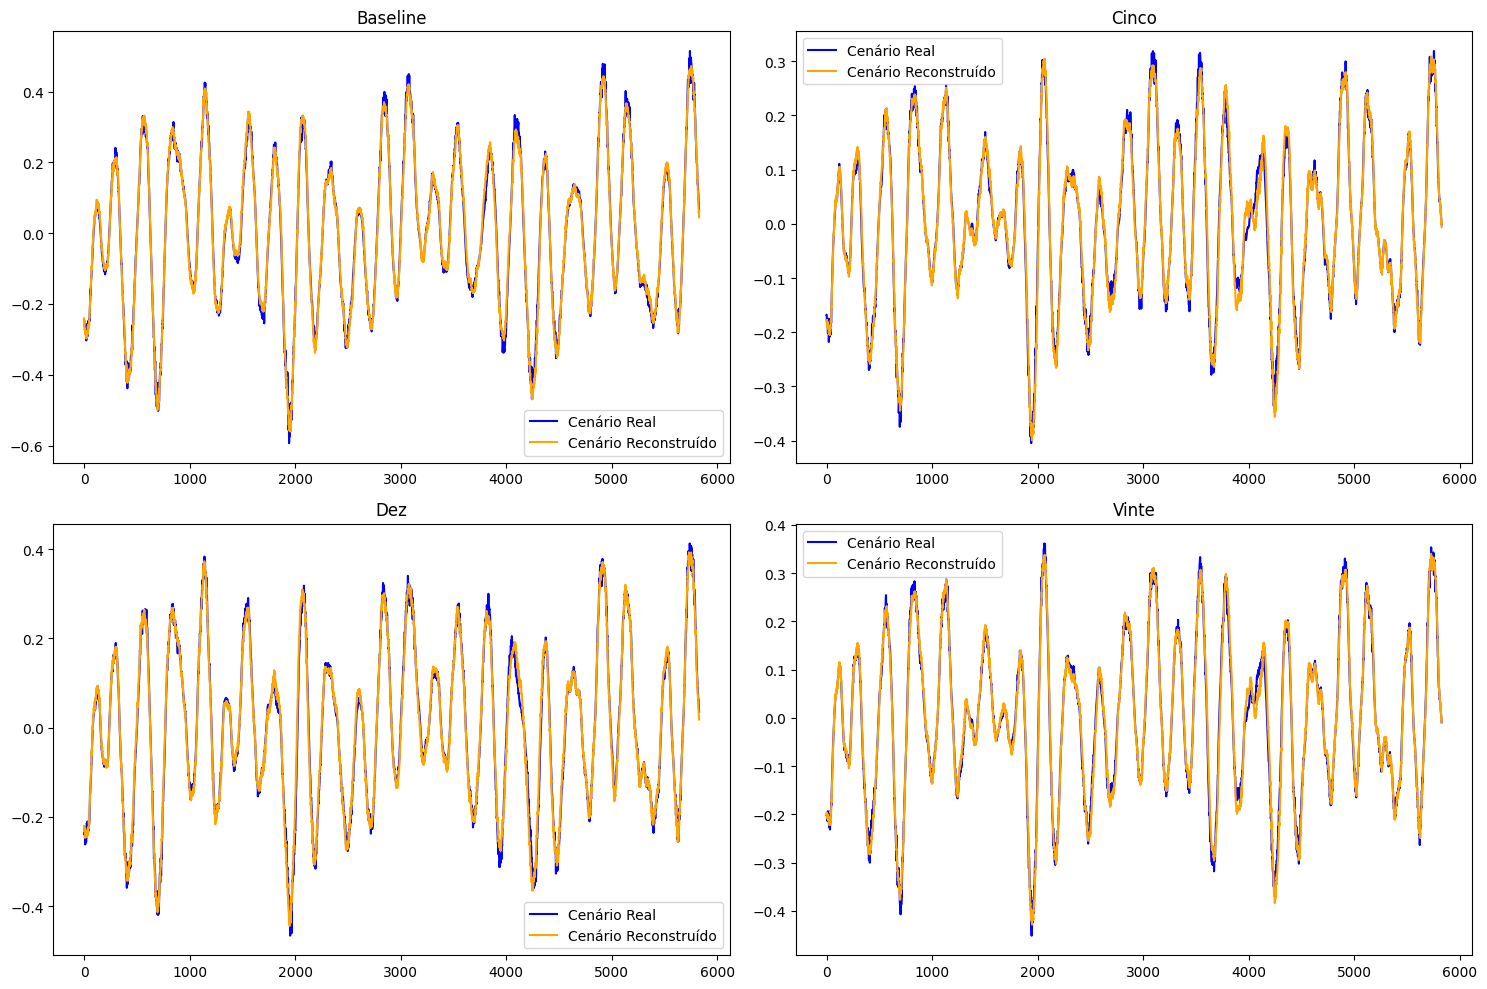

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Função para fazer a predição e plotar os resultados
def plot_prediction(model, dataset, label, ax):
    y = dataset.iloc[0].values.reshape(1, -1)
    y_pred = model.predict(y)

    # Supondo que x represente os pontos coletados
    x = np.arange(0, y.shape[1])

    # Plotando o cenário real (em azul)
    ax.plot(x, y[0], label='Cenário Real', color='blue')

    # Plotando o cenário reconstruído (em laranja)
    ax.plot(x, y_pred[0], label='Cenário Reconstruído', color='orange')

    # Adicionando legenda ao plot
    ax.legend()

    # Adicionando título ao plot
    ax.set_title(label)

# Criando e treinando o modelo
AE = AutoencoderHandler(X_train)
model = AE.model()

# Definindo o tamanho do grid
num_rows = 2
num_cols = 2

# Criando o grid de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Plotando os resultados para cada conjunto de dados
plot_datasets = [
    (dataBaseline_df, 'Baseline'),
    (dataCincoP_df, 'Cinco'),
    (dataDez_df, 'Dez'),
    (dataVinte_df, 'Vinte')
]

for i, (dataset, label) in enumerate(plot_datasets):
    row = i // num_cols
    col = i % num_cols
    plot_prediction(model, dataset, label, ax=axes[row, col])

# Ajustando o layout do grid
plt.tight_layout()

# Exibindo o grid de subplots
plt.show()


In [12]:
loss_final = AutoencoderHandler(X_train)
loss_final.final_loss(sparsity= 9.99999999e-02, rho= 4.99999990e-02, beta= 2.99999999e+00, epsilon= 1.20481896e-05, l1_lambda= 1.00000067e-01)

0.3340439200401306

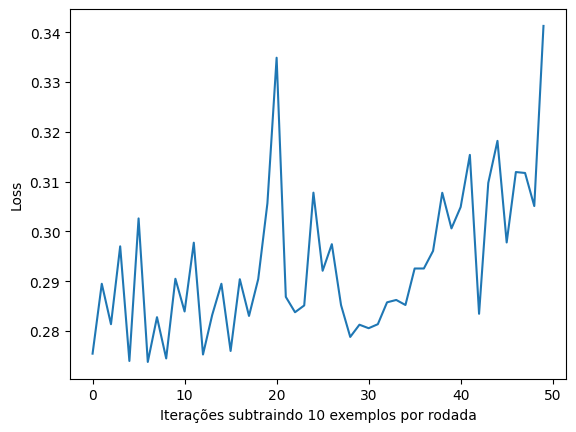

In [45]:
# Análise do aumento do loss com a diminuição da quantidade de dados

X_train_Loss = X_train.copy()  # Copy the original dataset to avoid modifying the original
loss_atual = []
num_rodagens = 0

while X_train_Loss.shape[0] > 10:
    autoencoder_handler = AutoencoderHandler(X_train_Loss)
    loss_final = autoencoder_handler.final_loss(sparsity=1.00000000e-01, rho=5.00000000e-02, beta=3.00000000e+00, epsilon=1.00031584e-05, l1_lambda=1.00000067e-03)
    loss_atual.append(loss_final)

    num_rodagens += 1
    drop_indices = np.random.choice(X_train_Loss.index, 20, replace=False)  # Remove 10 dados aleatórios
    X_train_Loss = X_train_Loss.drop(drop_indices)

arangeIters = np.arange(0, num_rodagens)

plt.plot(arangeIters, loss_atual)
plt.xlabel("Iterações subtraindo 10 exemplos por rodada")
plt.ylabel("Loss")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  activity_regularizer: Regularizer function applied to
2024-01-26 16:01:33.265182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


MSE Medio Total MAEBaseline : 0.0033216360811383627
MSE Medio Total MAECinco : 0.0028573830705451455
MSE Medio Total MAEDez : 0.002903538885783614
MSE Medio Total MAEVinte : 0.002861594301910189


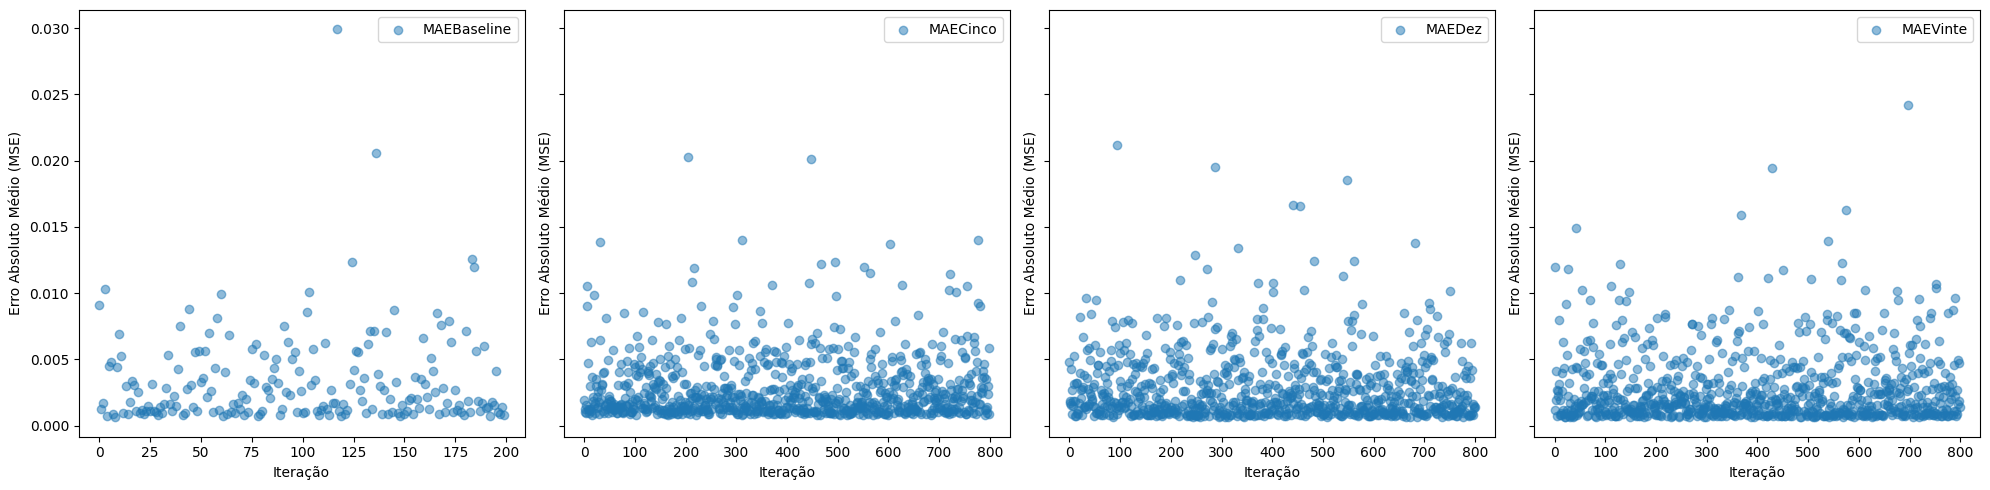

In [33]:
# Criando subplots para cada tipo de dano
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

handler = AutoencoderHandler(X_train)

# Adicionando quatro plots, um para cada tipo de dano
MSE_Baseline = handler.MSE_Dano_plot(X_test_baseline, label="MAEBaseline", ax=axes[0])

MSE_Cinco = handler.MSE_Dano_plot(X_test_cinco, label="MAECinco", ax=axes[1])

MSE_Dez = handler.MSE_Dano_plot(X_test_dez, label="MAEDez", ax=axes[2])

MSE_Vinte = handler.MSE_Dano_plot(X_test_vinte, label="MAEVinte", ax=axes[3])

plt.tight_layout()
plt.show()


In [10]:
handler = AutoencoderHandler(X_train)

MSE_Baseline = handler.MSE_Dano(dataBaseline_df, label="MSEBaseline")
MSE_Cinco = handler.MSE_Dano(dataCincoP_df, label="MSECinco")
MSE_Dez = handler.MSE_Dano(dataDez_df, label="MSEDez")
MSE_Vinte = handler.MSE_Dano(dataVinte_df, label="MSEVinte")

def mahalanobis(x):
    menor_mahalanobis = 10e5  # Número grande para ser substituído em sequência
    cenario_encontrado = ''
    
    cenarios = {'MSEBaseline': MSE_Baseline, 'MSECinco': MSE_Cinco, 'MSEDez': MSE_Dez, 'MSEVinte': MSE_Vinte}
    
    for nome_cenario, cenario in cenarios.items():
        media_mse_cenario = cenario[0]
        quadrado_std_cenario = cenario[1]
        mahalanobis_atual = np.sqrt(((x - media_mse_cenario) ** 2) / quadrado_std_cenario)
        
        if mahalanobis_atual < menor_mahalanobis:
            menor_mahalanobis = mahalanobis_atual
            cenario_encontrado = nome_cenario
    
    return cenario_encontrado


In [11]:

AE = AutoencoderHandler(X_train)
model = AE.model()

MSE_Medio = np.array([])  # Corrigindo a chamada para np.array([])
resultados = []
for i in range(dataCincoP_df.shape[0]):
    y = np.array(dataCincoP_df.iloc[i])
    y_predict = model.predict(dataCincoP_df.iloc[i].values.reshape(1, -1), verbose=0)
    y_predict = y_predict[0]
    MSE_Atual = np.mean((y_predict - y) ** 2)  # Calculando o MSE atual e usando np.mean()

    resultados.append(mahalanobis(MSE_Atual))

print(resultados)

['MSECinco', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEDez', 'MSEBaseline', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSECinco', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEDez', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEBaseline', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEBaseline', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEBaseline', 'MSEVinte', 'MSEBaseline', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSECinco', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEVinte', 'MSEDez', 'MSEDez', 'MSEVint

In [12]:
termos = resultados.__len__()
incorretos = 0

predicted_scenarios = []

for i in range(termos):
    actual_scenario = 'MSEBaseline' 

    if resultados[i] != actual_scenario:
        incorretos += 1

    predicted_scenarios.append(resultados[i])

print(f"Total de incorretos: {incorretos}")
for scenario in set(predicted_scenarios):
    count = predicted_scenarios.count(scenario)
    print(f"Predito como {scenario}: {count} vezes")


Total de incorretos: 933
Predito como MSEDez: 38 vezes
Predito como MSEBaseline: 67 vezes
Predito como MSECinco: 49 vezes
Predito como MSEVinte: 846 vezes
